### In the cell below, change PATH in os.chdir(PATH) to your local alignment folder with intersect.bam within it.

In [1]:
import os
os.chdir("/gpfs/home/asun/jin_lab/yap/pipeline0_bt2_local_alignment/split_s10")
print(os.getcwd())

/gpfs/group/jin/asun/yap/pipeline0_bt2_local_alignment/split_s10


In [2]:
import pandas as pd
import numpy as np
import subprocess
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from cemba_data.utilities import get_configuration
from cemba_data.mapping import cutoff_vs_cell_remain, plot_on_plate

### In the cell below, change output_dir to the path that you demultiplexed your YAP pipeline in.

In [3]:
output_dir = ''
plate_col = 'Plate'
color_quantile = (0.025, 0.975)

# Parameters
output_dir = "/gpfs/group/jin/asun/yap/pipeline2_yap_s10/yap_demultiplex"
output_dir = pathlib.Path(output_dir)
mapping_summary = pd.read_csv(output_dir / 'stats/MappingSummary.csv.gz', index_col=0)
config = get_configuration(output_dir / 'mapping_config.ini')

In [4]:
def visualize_local(data, hue):
    vmax = data[hue].max()
    fig2, plate_names, plate_datas = plot_on_plate(
        data=data,
        hue=hue,
        groupby=plate_col,
        vmin=0,
        vmax=vmax,
        aggregation_func=lambda i: i.mean())
    return

In [ ]:
# Function to reverse complement if RC column is "RC"
def conditional_reverse_complement(row):
    if row["RC"] == "RC":
        return str(Seq(row["SEQ"]).reverse_complement())
    return row["SEQ"]  # Keep the sequence unchanged if not "RC"

# Load BAM into DataFrame
sam_output = subprocess.run(["samtools", "view", "intersect.bam"], capture_output=True, text=True)
sam_lines = sam_output.stdout.strip().split("\n")

# Convert SAM to DataFrame
columns = ["QNAME", "FLAG", "RNAME", "POS", "MAPQ", "CIGAR", "RNEXT", "PNEXT", "TLEN", "SEQ", "QUAL"]
data = [line.split("\t")[:11] for line in sam_lines]
df = pd.DataFrame(data, columns=columns)

# Convert FLAG to numeric
df["FLAG"] = pd.to_numeric(df["FLAG"])
df["RC"] = df["FLAG"].apply(lambda x: "RC" if x & 16 else "FORWARD")

rp_indices = pd.read_csv("/gpfs/home/asun/jin_lab/yap/raw_data/384RPIndexes.csv")
rp_indices = rp_indices.rename(columns={"RP Index": "RP_INDEX", "Position": "WELL"})   

# Apply the function to create the TRUE_SEQ column
df["TRUE_SEQ"] = df.apply(conditional_reverse_complement, axis=1)

df["RP_INDEX"] = df["TRUE_SEQ"].apply(lambda x: x[:8])

# Assign read type
df["READ_TYPE"] = df["FLAG"].apply(lambda x: "READ_1" if x & 64 else ("READ_2" if x & 128 else "UNPAIRED"))

df["READ_1"] = ""

readnames = df.loc[(df["READ_TYPE"] == "READ_2"), "QNAME"].tolist()

with open("grna_r1.fq", "r") as fq:
    while True:
        header = fq.readline().strip()  
        seq = fq.readline().strip()     
        fq.readline()                   
        fq.readline()                   
        
        if not header:
            break  # End of file
        
        qname = header.lstrip("@")

        if qname in df["QNAME"].values:
            first_8_bp = seq[:8]  # Extract the first 8 bases
            df.loc[df["QNAME"] == qname, "READ_1"] = seq
            df.loc[df["QNAME"] == qname, "RP_INDEX"] = first_8_bp


df = df.merge(rp_indices, on=["RP_INDEX"], how="left")
df_filtered = df.drop_duplicates(subset='QNAME', keep='first')
len(df_filtered)

result = (
    df_filtered.groupby(['WELL', 'RNAME'])
    .size()
    .unstack(fill_value=0)
)

# This gives you the desired result
result = result.astype(int)
result = result.reset_index()

In [6]:
len(df_filtered)


112

In [35]:
merged_local_mapping = pd.merge(mapping_summary, result, how="left", left_on="RandomIndex", right_on="WELL")
merged_local_mapping = merged_local_mapping.drop(columns='WELL')
merged_local_mapping[result.columns[1:]] = merged_local_mapping[result.columns[1:]].fillna(0).astype(int)
merged_local_mapping["Total_grna"] = merged_local_mapping[result.columns[1:]].sum(axis=1)
merged_local_mapping[result.columns[1:]] = merged_local_mapping[result.columns[1:]].replace(0, np.nan)
merged_local_mapping["Total_grna"] = merged_local_mapping["Total_grna"].replace(0, np.nan)
merged_local_mapping

,Plate,PCRIndex,MultiplexGroup,RandomIndex,Col384,Row384,Plate.1,PCRIndex.1,MultiplexGroup.1,RandomIndex.1,...,DNAReadsYield,RNAReadsYield,RNA/(DNA+RNA),Dnmt3a_g1,Dnmt3a_g2,Foxg1_g1,Foxg1_g2,Safe_g1,Safe_g2,Total_grna
0,S_10,A1,1,A1,0,0,S_10,A1,1,A1,...,0.000025,0.064411,1.624600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S_10,A1,1,A13,12,0,S_10,A1,1,A13,...,0.000345,0.535345,1.746064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S_10,A1,1,A14,13,0,S_10,A1,1,A14,...,0.000261,0.497886,1.774118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,S_10,A1,1,A2,1,0,S_10,A1,1,A2,...,0.000021,0.023656,1.674074,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S_10,A1,1,B1,0,1,S_10,A1,1,B1,...,0.000003,0.008807,1.703022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,S_10,A1,2,O4,3,14,S_10,A1,2,O4,...,0.000018,0.020728,1.696121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
380,S_10,A1,2,P15,14,15,S_10,A1,2,P15,...,0.000267,0.500313,1.917250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
381,S_10,A1,2,P16,15,15,S_10,A1,2,P16,...,0.000369,0.429995,1.849478,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382,S_10,A1,2,P3,2,15,S_10,A1,2,P3,...,0.000011,0.017556,1.691777,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### In the cell below, change hue to one of the following options depending on what you want to visualize: "Total_grna", "Foxg1_g1", "Foxg1_g2", "Dnmt3a_g1", "Dnmt3a_g2", "Safe_g1", "Safe_g2".

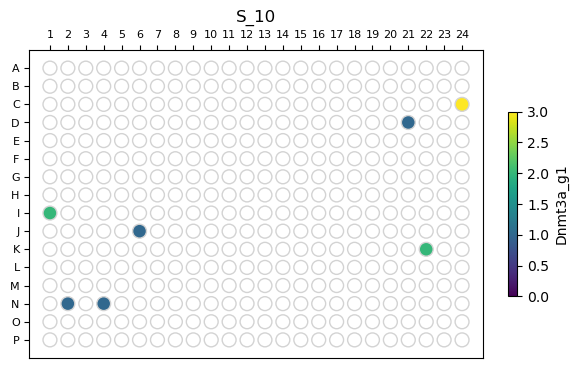

In [37]:
visualize_local(merged_local_mapping, hue="Dnmt3a_g1")